<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

## Kerry Kurcz
### MSDS453 - Research Assignment 02
#### Classification and Clustering
##### Code based on https://github.com/djp840/MSDS_453_Public

Clustering methods compute a similarity (or closeness) measure, such as Euclidean distance, in order to decide whether two documents are ‘similar’ or not.  

Use the entire class corpus and do sentiment analysis for the positive and negative reviews.

Topic modeling is another way to group ‘similar’ documents into ‘clusters’. 

In [1]:
import pandas as pd
import os
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import random
from dataclasses import dataclass

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

import gensim # https://pypi.org/project/gensim/
from gensim import corpora, similarities
from gensim.models import Word2Vec, LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB

import scipy.cluster.hierarchy

from IPython.display import display, HTML

from typing import List, Callable, Dict

from time import asctime
import unicodedata

#import pkg_resources
#pkg_resources.require("gensim<=3.8.3");
#print("Genism Version: ", gensim.__version__)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def get_time(please_print=False):
    TIME = asctime().replace(" ", "").replace(":", "")
    TIME = re.sub(r'[A-z]', '', TIME)
    if please_print:
        print("The current time is", TIME)
    return TIME

from sklearn.decomposition import TruncatedSVD

In [2]:
TIME = get_time(please_print=True)

The current time is 200132472022


In [3]:
PATH = "/Users/kerry/Projects/msds453/random_nlp/week4"

<div class="alert alert-block alert-info">
<b> NLTK downloads </b>
</div>

### NLTK Downloads

In [4]:
# Only run this once, they will be downloaded.
#nltk.download('stopwords',quiet=True)
#nltk.download('wordnet',quiet=True)
#nltk.download('punkt',quiet=True)
#nltk.download('omw-1.4',quiet=True)

## Data Wrangling Utility Functions

## Functions Latent Semantic Analysis, Latent Dirichlet Allocation, Word2Vec Matrix 
1. Latent Semantic Analysis 
2. Latent Dirichlet Allocation
3. Word2Vec Matrix creation

In [5]:
def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    
    # mess with alpha 0.5, 0.6
    # beta 0.1
    # more words
    # higher alpha documents contain more similar topic contents
    
    ldamodel = LdaModel(doc_term_matrix
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,alpha='auto' # what does auto do
#                        ,eta='auto' #??
                        ,decay=0.1
                        ,iterations=100 # mess with this; min 100
                        ,random_state=23
                        ,chunksize=1000
                        ,passes=20) # min 20; epochs?
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

def lda(tfidf_matrix, terms, topics = 3, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 3
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)
    
def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the 
    #tokenized text and matrix size
    
    #word to vec
    model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df

## Topic Modeling Functions: LSA

In [6]:
def lsa(tfidf_matrix, n_components = 10):
    """
    trash, but keeping here bc printing the attritubes make me feel like I know what I'm doing
    """
    
    LSA = TruncatedSVD(n_components=10)
    FIT = LSA.fit(X=tfidf_matrix) # X is training data; {array-like, sparse matrix} of shape (n_samples, n_features)
    
    print("components")
    print(LSA.components_)
    print("explained variance")
    print(LSA.explained_variance_)
    print("explained variance ratio")
    print(LSA.explained_variance_ratio_)
    print("n features in")
    print(LSA.n_features_in_)
    print("feature names")
    print(LSA.feature_names_in_)
    
    return FIT


def create_gensim_lsa_model(doc_clean, number_of_topics, words):
    """
    Creating the term dictionary of our courpus, 
    where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    """
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    # train model
    lsamodel = LsiModel(doc_term_matrix # vector of unique terms per doc for all docs; try with tfitdf? doc2vec?
                        ,num_topics=number_of_topics
                        ,id2word = dictionary
                        ,power_iters=100
#                        ,words=10
                       )
#    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

## Modeling Functions: KMeans, SVM, Logistic, Naive Bayes, Randomforest

In [7]:
def k_means(titles, tfidf_matrix, k=3):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    return cluster_title, clusters, frame, km

def classifiers(x, y, model_type, cv = 3):
    
    #this function is to fit 3 different model scenarios.  Support vector machines, logistic regressions, naive bayes.
    #svm = Support vector machin
    #logistic = Logistic regression
    #naive_bayes = Naive Bayes Multinomial
    
    #can define cv value for cross validation.
    
    #function returns the train test split scores of each model.

    if model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()
    
    elif model_type == 'randomforest':
        print("randomforest")
        model = RandomForestClassifier()
        
    accy = []
        
    for idx in range(0, cv):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10)
        model.fit(X_train, y_train)

        predictions = model.predict(X_test)
        accy.append(accuracy_score(y_test, predictions))
        
    return accy

## Visualization Utility Functions

In [8]:
def plot_lsa(number_of_topics, words):

    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model

def plot_kmeans(k_value, dimensions=2):
    """
    clusters is a list of 0,1,1,2,3,2,1 if you have like 4 clusters
    cluster_dict is a dictionary; {0: [all, the docs, in, cluster 0], . . . k: ['doc1', 'docwhatever']}
    k_means_df is a df with an index no one uses, a cluster (same as clusters),
        a doc name, and the text in that document
    k_value is value for k clusters pleS
    
    flipping yikes: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    """
    cluster_dict, clusters, k_means_df, km = k_means(titles, tfidf_matrix, k = k_value)

    #mds = MDS(n_components = dimensions, dissimilarity = "precomputed", random_state = 8675309)
    mds = MDS(n_components = dimensions, dissimilarity = "euclidean", random_state = 8675309)
    # Multi-Dimensional Scaling . . . used for perceptual mapping
    # Similar to PCA. . . .
    # Metric Multidimensional Scaling is often used for Perceptual Mapping 
    # (creating maps based on a different-than-usual measure of distance) and for Product Development.
    # source : https://towardsdatascience.com/multidimensional-scaling-d84c2a998f72#:~:text=Metric%20Multidimensional%20Scaling%20is%20often,distance)%20and%20for%20Product%20Development.
    
    dist = 1 - cosine_similarity(tfidf_matrix) # 1 - cosine_similarity(TFIDF_matrix) | dist = 1 + cosine_similarity(TFIDF_matrix)
    # dist is 200 x 200
    
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples) i.e. 200 x (2 or 3 . . .nbr of dimensions)
    if dimensions==2:
        xs, ys = pos[:, 0], pos[:, 1]
        df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 
    else:
        xs, ys, zs = pos[:, 0], pos[:, 1], pos[:, 2]
        df = pd.DataFrame(dict(x=xs, y=ys, z=zs, label=clusters, title=range(0,len(clusters)))) 

    # df , of shape 200 x (4 or 5), 
    # has the result of the MDS plus the cluster numbers and titles
    
    # then group by cluster
    groups = df.groupby('label')
    
    if dimensions == 2:
        fig, ax = plt.subplots(figsize=(20,20)) # set size
        ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    else:
        fig = plt.figure(figsize = (15,15))
        ax = fig.add_subplot(111, projection='3d')

    for name, group in groups:
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        if dimensions==2:
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label = (f"cluster {group.label.iloc[0]}"), color=color, 
                mec='none')
            
        else:
            ax.plot(group.x, group.y, group.z, marker='o', linestyle='', ms=12,
                    label = (f"cluster {group.label.iloc[0]}"), color=color, 
                    mec='none')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    if dimensions==3:
        ax.set_zlabel('z')
    
    plt.title(f"k-means cluster plot given k={k_value} and dimensions={dimensions}")

    ax.legend(loc='lower left')

    TIME = get_time()
    plt.savefig(f"{PATH}/{TIME}_cluster.png")
    
    # prints the clusters for reference
    for KEY, VAL in cluster_dict.items():
        print(f"cluster {KEY} : ", VAL, "\n")


In [9]:
def strip_accents(STR):
    return ''.join(c for c in unicodedata.normalize('NFD', STR)
                   if unicodedata.category(c) != 'Mn')

def clean_doc(doc): 
    """
    Given a string doc,
    this function cleans the doc
    of . . .
    non-ascii chars
    punctuation
    anything other than lower case words
    non-alphabetic tokens
    stop words
    tokens shorter than length 3
    stem, lemma are also options
    returns the list of tokens.
    """
    doc = strip_accents(doc) # replaces non-ascii with utf-friendly chars
    doc = re.sub(r'[^\x00-\x7F]', '', doc) # removes any remaining non-ascii chars
    
    tokens = doc.split() # set the tone
    
    # punctuation situation
    sub_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [sub_punc.sub('', tkn) for tkn in tokens]
    
    # alpha
    tokens = [tkn for tkn in tokens if tkn.isalpha()]
    
    # shorties
    tokens = [tkn for tkn in tokens if len(tkn) > 3]
    
    # capitalization
    tokens = [tkn.lower() for tkn in tokens]
    
    # stop words
    stop_words = set(stopwords.words('english')) # add top freq words up in here
    tokens = [tkn for tkn in tokens if not tkn in stop_words]
    
    # word stemming    
#    ps = PorterStemmer()
#    tokens = [ps.stem(tkn) for tkn in tokens]
    
    # lemmatizing
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(wrd) for wrd in tokens]
    
    return tokens # tokens is a list

## Loading the Class Corpus

In [10]:
#read in class corpus csv into python
data=pd.read_csv(r'~/Projects/msds453/MSDS_453_Public/MSDS453_ClassCorpus/ClassCorpus_Final_v3_20220710.csv')

#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))

#creating final processed text variables for matrix creation
#final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
final_processed_text = [' '.join(x) for x in data['processed_text']]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text']#.tolist()

In [11]:
data['processed_text']

0      [jimmy, fallons, screen, career, even, get, st...
1      [getting, nominated, chicago, making, boxoffic...
2      [queen, latifah, handily, walked, away, show, ...
3      [jimmy, fallon, leaf, osaturday, night, liveo,...
4      [taxiecasts, jimmyefallon, officer, andy, wash...
                             ...                        
195    [inception, make, average, moviegoer, feel, sm...
196    [basic, idea, story, good, money, spectacular,...
197    [unless, call, movie, masterpiece, damn, word,...
198    [reading, amazing, review, seeing, score, best...
199    [shame, movie, rated, highly, imdb, tell, movi...
Name: processed_text, Length: 200, dtype: object

1. Dataframe = corpus_df
2. List = documents (Document ID, Text)

In [12]:
#type(data['processed_text'][0])

In [13]:
theString = data['Text'].iloc[3]

In [14]:
[' '.join(xyz) for xyz in data['processed_text']]==[' '.join(x) for x in data['processed_text'].tolist()]

True

In [15]:
data

,Doc_ID,DSI_Title,Text,Submission File Name,Student Name,Genre of Movie,Review Type (pos or neg),Movie Title,processed_text
0,160,ARE_Doc1_Taxi,Jimmy Fallon's big screen career may be over b...,ARE_Doc1_Taxi,ARE,Action,Negative,Taxi,"[jimmy, fallons, screen, career, even, get, st..."
1,161,ARE_Doc2_Taxi,"After getting nominated for ""Chicago"" and maki...",ARE_Doc2_Taxi,ARE,Action,Positive,Taxi,"[getting, nominated, chicago, making, boxoffic..."
2,162,ARE_Doc3_Taxi,Queen Latifah handily walked away with the sho...,ARE_Doc3_Taxi,ARE,Action,Negative,Taxi,"[queen, latifah, handily, walked, away, show, ..."
3,163,ARE_Doc4_Taxi,So Jimmy Fallon leaves ÒSaturday Night LiveÓ a...,ARE_Doc4_Taxi,ARE,Action,Negative,Taxi,"[jimmy, fallon, leaf, osaturday, night, liveo,..."
4,164,ARE_Doc5_Taxi,TaxiÊcasts JimmyÊFallon as Officer Andy Washbu...,ARE_Doc5_Taxi,ARE,Action,Negative,Taxi,"[taxiecasts, jimmyefallon, officer, andy, wash..."
...,...,...,...,...,...,...,...,...,...
195,85,MGB_Doc6_Inception,Inception makes the average moviegoer feel sma...,MGB_Doc6_Inception,MGB,Action,Negative,Inception,"[inception, make, average, moviegoer, feel, sm..."
196,86,MGB_Doc7_Inception,"You have this basic idea and the story, they a...",MGB_Doc7_Inception,MGB,Action,Negative,Inception,"[basic, idea, story, good, money, spectacular,..."
197,87,MGB_Doc8_Inception,Unless you call this movie a masterpiece. Then...,MGB_Doc8_Inception,MGB,Action,Negative,Inception,"[unless, call, movie, masterpiece, damn, word,..."
198,88,MGB_Doc9_Inception,After reading all the amazing reviews and seei...,MGB_Doc9_Inception,MGB,Action,Negative,Inception,"[reading, amazing, review, seeing, score, best..."


### K-Means Experiment with 3D Plot

## Exploritory Data Analysis

In [16]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)


def get_corpus_df(path):
    data = pd.read_csv(path)
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data


@dataclass
class Document:
    doc_id: str
    text: str

In [17]:
CORPUS_PATH = '~/Projects/msds453/MSDS_453_Public/MSDS453_ClassCorpus/ClassCorpus_Final_v3_20220710.csv' # copy?
corpus_df = get_corpus_df(CORPUS_PATH)
documents = [Document(x, y) for x, y in zip(corpus_df.Doc_ID, corpus_df.Text)]

In [18]:
corpus_df.shape

(200, 9)

In [19]:
corpus_df.head().T

Doc_ID,40,41,42,43,44
DSI_Title,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Text,Boredom sets in long before the start of Angel...,\nWho ARE all these people?\n\nThat was what...,Ric Roman Waughs Angel Has Fallen sees U.S. S...,There is a certain mindless pleasure in the Fa...,"No, you dont need to have seen Olympus Has F..."
Submission File Name,KCM_Doc1_AngelHasFallen,KCM_Doc2_AngelHasFallen,KCM_Doc3_AngelHasFallen,KCM_Doc4_AngelHasFallen,KCM_Doc5_AngelHasFallen
Student Name,KCM,KCM,KCM,KCM,KCM
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen,Angel Has Fallen
Descriptor,Action_Angel Has Fallen_N_40,Action_Angel Has Fallen_N_41,Action_Angel Has Fallen_N_42,Action_Angel Has Fallen_N_43,Action_Angel Has Fallen_N_44
Doc_ID,40,41,42,43,44


In [20]:
print(corpus_df.info());

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 40 to 199
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB
None


In [21]:
print(corpus_df['Movie Title'].unique())

['Angel Has Fallen' 'Inception' 'No Time To Die' 'Taken' 'Taxi'
 'Despicable Me 3' 'Dirty Grandpa' 'Holmes and Watson' 'Legally Blonde'
 'The Lost City' 'Drag me to hell' 'Fresh' 'It Chapter Two'
 'The Toxic Avenger' 'US' 'Batman' 'Equilibrium' 'Minority Report'
 'Oblivion' 'Pitch Black']


## NLP Supervised and Unsupervised Learning Methods:
1. K-Means Clustering (Unsupervised)
2. Support Vector Machines (SVMs) (Supervised)
3. (Multinomial) Naïve Bayes (MultinomialNB) (Supervised)
4. Logistic Regression (Supervised)

### Generate TF-IDF For Analysis

In [22]:
def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix #,words

In [23]:
tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,1))

## Latent Semantic Analysis - Research Number of Topics and Number of Words

### Experiment with LSA algorithms

In [24]:
FIT = lsa(tfidf_matrix=tfidf_matrix, n_components = 10)

components
[[ 1.02352819e-03  1.52073971e-03  9.17113798e-04 ...  8.44069718e-04
   3.52490456e-04  7.99455556e-03]
 [-6.55602617e-04 -6.88743783e-04 -5.03937475e-04 ... -1.06786712e-03
  -2.15794112e-04 -4.45018403e-03]
 [ 1.91802462e-04  3.66137758e-04  2.09107568e-05 ...  1.61250510e-03
  -6.06723871e-04 -4.52069789e-03]
 ...
 [ 5.60396895e-03  1.18296558e-02  9.16818182e-03 ... -1.67133212e-03
  -7.17240044e-05 -1.38347130e-02]
 [-5.19804634e-03 -9.77015515e-03 -8.05838988e-03 ... -3.15446970e-04
   1.42232160e-04  1.50601397e-03]
 [ 8.47638825e-04  5.70767565e-04  9.00510024e-04 ...  7.28229015e-04
   2.15703420e-04  5.90305385e-03]]
explained variance
[0.00268521 0.02033963 0.01808995 0.01745255 0.01710656 0.01629441
 0.01615967 0.0153392  0.01476309 0.01446747]
explained variance ratio
[0.00286389 0.02169309 0.01929371 0.01861389 0.01824489 0.01737868
 0.01723499 0.01635992 0.01574547 0.01543018]
n features in
14950
feature names
['aafternoon' 'aand' 'aare' ... 'zonk' 'zoom' 'zo

In [25]:
len(FIT.components_[0])

14950

In [26]:
len(FIT.components_)

10

In [27]:
FIT.singular_values_

array([3.59941639, 2.01768953, 1.9021851 , 1.86836507, 1.85121616,
       1.80529457, 1.79776375, 1.75284166, 1.71839509, 1.70127466])

In [28]:
print(FIT.explained_variance_ratio_.sum()) # sad

0.1628587075944933


### Compare LSA Model Coherence
#### higher coherence will allot easier interpretation of the topic; higher coherence should enable more intuitive topics

##### using gensim package

In [29]:
topics = [7, 2, 10] # 6
#topics = [idx for idx in range(3, 11)]

coherence_values = []
for t in topics:
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text, t, 10)

    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)

    
coherence ={'7 topics & 10 words':coherence_values[0], # 42% without stemming
            '2 topics & 10 words': coherence_values[1], # 45 and highest % with stemming
            '20 topics & 10 words':coherence_values[2],} #40% without stemming

for KEY, VAL in coherence.items():
    print("{} : {} %".format(KEY, round(100*VAL, 2)))

# higher coherence will allot easier interpretation of the topic
# higher coherence should enable more intuitive topics

#print(coherence_values)

# using umass showed occasionally -- not always the opposite sign like if c_v was -0.123*world
# umass was like 0.132*would
# for many but not all words. idk
# coherence was also this, which I guess is normal based on these plots I found 
# {'7 topic 10 words': -5.568296587099545, '2 topic 10 words': -7.528726671018092, '20 topic 10 words': -4.685267617842075}
# the plots : https://www.researchgate.net/figure/Topic-coherence-scores-on-C-V-C-A-NPMI-and-UMass-at-different-temperatures_fig5_357288103

7 topics & 10 words : 30.34 %
2 topics & 10 words : 25.18 %
20 topics & 10 words : 29.76 %


## Cluster Model Research: KMeans, SVM, Logistic, Naive Bayes, Randomforest

### KMeans Clustering

### K-Means Experiment with 3D Plot

<div class="alert alert-block alert-success">
    <b>sklearn.cluster.KMeans</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html<br><br>
<b>KMeans Default Parameters</b>:<br>
    class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
    </div>

In [30]:
cluster_title, clusters, k_means_df, km = k_means(titles, tfidf_matrix, k = 2)

cluster 0 :  ['DRN_Doc1_EQUILIBRIUM', 'DRN_Doc2_EQUILIBRIUM', 'DRN_Doc3_EQUILIBRIUM', 'DRN_Doc4_EQUILIBRIUM', 'DRN_Doc5_EQUILIBRIUM', 'DRN_Doc6_EQUILIBRIUM', 'DRN_Doc7_EQUILIBRIUM', 'DRN_Doc8_EQUILIBRIUM', 'DRN_Doc9_EQUILIBRIUM', 'DRN_Doc10_EQUILIBRIUM', 'JMI_Doc3_Fresh', 'JMI_Doc5_Fresh', 'JMI_Doc9_Fresh', 'JMI_Doc10_Fresh', 'RSV_Doc1_MinorityReport', 'RSV_Doc2_MinorityReport', 'RSV_Doc3_MinorityReport', 'RSV_Doc4_MinorityReport', 'RSV_Doc5_MinorityReport', 'RSV_Doc6_MinorityReport', 'RSV_Doc7_MinorityReport', 'RSV_Doc8_MinorityReport', 'RSV_Doc9_MinorityReport', 'RSV_Doc10_MinorityReport', 'JTG_Doc1_Oblivion', 'JTG_Doc2_Oblivion', 'JTG_Doc3_Oblivion', 'JTG_Doc4_Oblivion', 'JTG_Doc5_Oblivion', 'JTG_Doc6_Oblivion', 'JTG_Doc7_Oblivion', 'JTG_Doc8_Oblivion', 'JTG_Doc9_Oblivion', 'JTG_Doc10_Oblivion', 'JSA_Doc1_PitchBlack', 'JSA_Doc2_PitchBlack', 'JSA_Doc3_PitchBlack', 'JSA_Doc4_PitchBlack', 'JSA_Doc5_PitchBlack', 'JSA_Doc6_PitchBlack', 'JSA_Doc7_PitchBlack', 'JSA_Doc8_PitchBlack', 'JSA_D

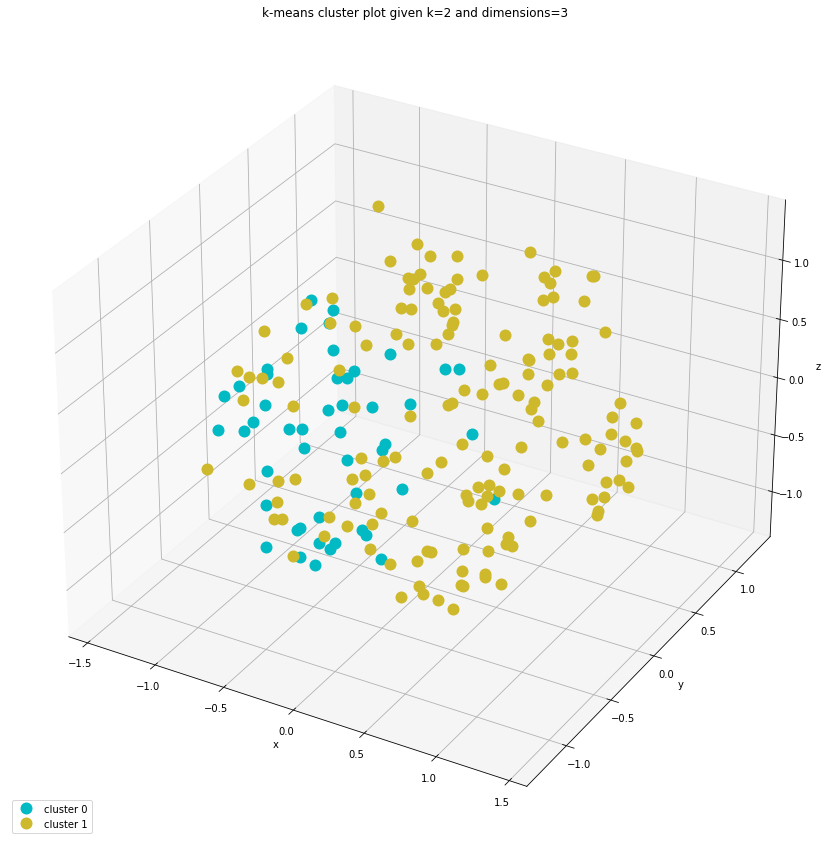

In [31]:
%matplotlib inline

# this does not suggest positive and negative reviews is a 50/50 split
plot_kmeans(k_value=2, dimensions=3)

cluster 0 :  ['HLU_Doc3_US', 'HLU_Doc5_US', 'HLU_Doc6_US', 'HLU_Doc7_US', 'HLU_Doc8_US', 'JMI_Doc1_Fresh', 'JMI_Doc2_Fresh', 'JMI_Doc3_Fresh', 'JMI_Doc4_Fresh', 'JMI_Doc5_Fresh', 'JMI_Doc6_Fresh', 'JMI_Doc7_Fresh', 'JMI_Doc8_Fresh', 'JMI_Doc9_Fresh', 'JMI_Doc10_Fresh', 'ARB_Doc1_HolmesAndWatson', 'ARB_Doc5_HolmesAndWatson', 'ARB_Doc7_HolmesAndWatson', 'DWB_Doc1_LegallyBlonde', 'DWB_Doc2_LegallyBlonde', 'DWB_Doc3_LegallyBlonde', 'DWB_Doc4_LegallyBlonde', 'DWB_Doc5_LegallyBlonde', 'DWB_Doc6_LegallyBlonde', 'DWB_Doc7_LegallyBlonde', 'DWB_Doc8_LegallyBlonde', 'DWB_Doc9_LegallyBlonde', 'DWB_Doc10_LegallyBlonde', 'KKN_Doc1_ToxicAvenger', 'KKN_Doc2_ToxicAvenger', 'KKN_Doc3_ToxicAvenger', 'KKN_Doc4_ToxicAvenger', 'KKN_Doc5_ToxicAvenger', 'KKN_Doc6_ToxicAvenger', 'KKN_Doc7_ToxicAvenger', 'KKN_Doc8_ToxicAvenger', 'KKN_Doc9_ToxicAvenger', 'KKN_Doc10_ToxicAvenger', 'JLV_Doc1_Batman', 'JLV_Doc2_Batman', 'JLV_Doc3_Batman', 'JLV_Doc4_Batman', 'JLV_Doc5_Batman', 'JLV_Doc6_Batman', 'JLV_Doc7_Batman', '

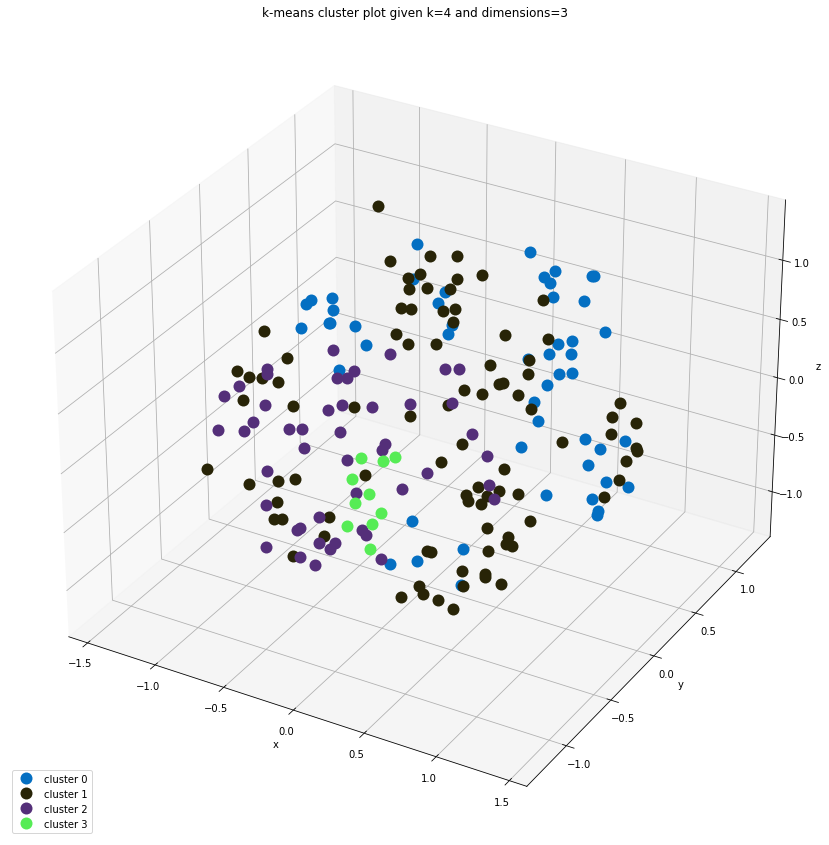

In [32]:
%matplotlib inline

plot_kmeans(k_value=4, dimensions=3)

cluster 0 :  ['SDT_Doc1_NoTimeToDie', 'SDT_Doc2_NoTimeToDie', 'SDT_Doc3_NoTimeToDie', 'SDT_Doc4_NoTimeToDie', 'SDT_Doc5_NoTimeToDie', 'SDT_Doc6_NoTimeToDie', 'SDT_Doc7_NoTimeToDie', 'SDT_Doc8_NoTimeToDie', 'SDT_Doc9_NoTimeToDie', 'SDT_Doc10_NoTimeToDie'] 

cluster 1 :  ['HLU_Doc1_US', 'HLU_Doc2_US', 'HLU_Doc3_US', 'HLU_Doc4_US', 'HLU_Doc5_US', 'HLU_Doc6_US', 'HLU_Doc7_US', 'HLU_Doc8_US', 'HLU_Doc9_US', 'HLU_Doc10_US'] 

cluster 2 :  ['DWM_Doc1_TheLostCity', 'DWM_Doc2_TheLostCity', 'DWM_Doc3_TheLostCity', 'DWM_Doc4_TheLostCity', 'DWM_Doc5_TheLostCity', 'DWM_Doc6_TheLostCity', 'DWM_Doc7_TheLostCity', 'DWM_Doc8_TheLostCity', 'DWM_Doc9_TheLostCity', 'DWM_Doc10_TheLostCity'] 

cluster 3 :  ['DRN_Doc1_EQUILIBRIUM', 'DRN_Doc2_EQUILIBRIUM', 'DRN_Doc3_EQUILIBRIUM', 'DRN_Doc4_EQUILIBRIUM', 'DRN_Doc5_EQUILIBRIUM', 'DRN_Doc6_EQUILIBRIUM', 'DRN_Doc7_EQUILIBRIUM', 'DRN_Doc8_EQUILIBRIUM', 'DRN_Doc9_EQUILIBRIUM', 'DRN_Doc10_EQUILIBRIUM'] 

cluster 4 :  ['PYC_Doc1_DirtyGrandpa', 'PYC_Doc2_DirtyGrandpa'

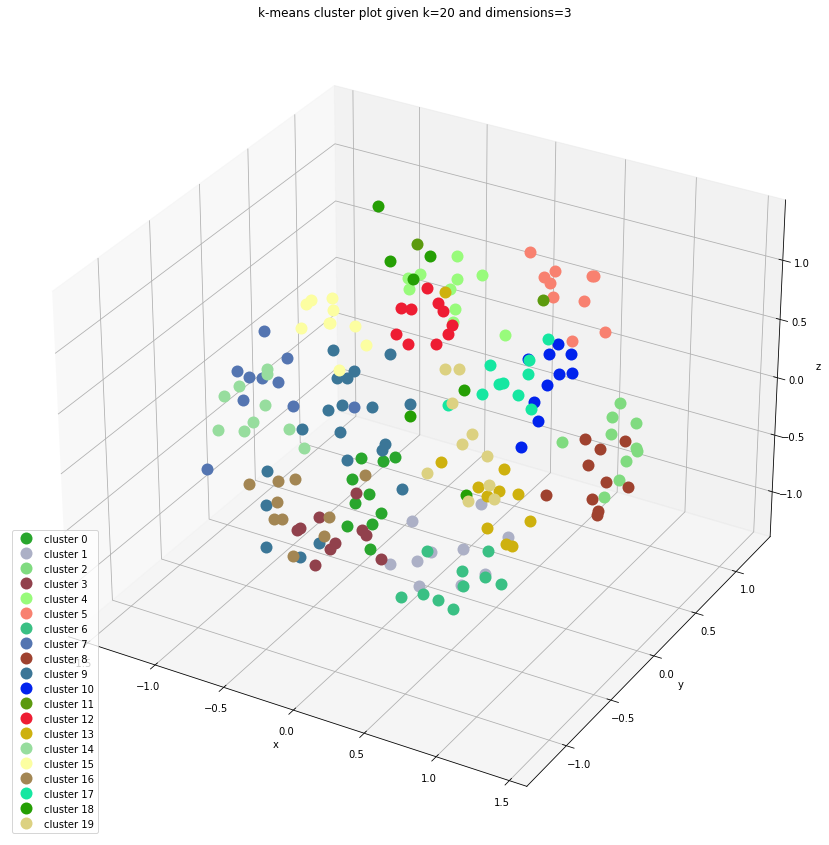

In [33]:
plot_kmeans(k_value=20, dimensions=3)

cluster 0 :  ['JTG_Doc1_Oblivion', 'JTG_Doc2_Oblivion', 'JTG_Doc3_Oblivion', 'JTG_Doc4_Oblivion', 'JTG_Doc5_Oblivion', 'JTG_Doc6_Oblivion', 'JTG_Doc7_Oblivion', 'JTG_Doc8_Oblivion', 'JTG_Doc9_Oblivion', 'JTG_Doc10_Oblivion', 'JSA_Doc1_PitchBlack', 'JSA_Doc2_PitchBlack', 'JSA_Doc3_PitchBlack', 'JSA_Doc4_PitchBlack', 'JSA_Doc5_PitchBlack', 'JSA_Doc6_PitchBlack', 'JSA_Doc7_PitchBlack', 'JSA_Doc8_PitchBlack', 'JSA_Doc9_PitchBlack', 'JSA_Doc10_PitchBlack'] 

cluster 1 :  ['JLV_Doc1_Batman', 'JLV_Doc2_Batman', 'JLV_Doc3_Batman', 'JLV_Doc4_Batman', 'JLV_Doc5_Batman', 'JLV_Doc6_Batman', 'JLV_Doc7_Batman', 'JLV_Doc8_Batman', 'JLV_Doc9_Batman', 'JLV_Doc10_Batman'] 

cluster 2 :  ['ARE_Doc1_Taxi', 'ARE_Doc2_Taxi', 'ARE_Doc3_Taxi', 'ARE_Doc4_Taxi', 'ARE_Doc5_Taxi', 'ARE_Doc6_Taxi', 'ARE_Doc7_Taxi', 'ARE_Doc8_Taxi', 'ARE_Doc9_Taxi', 'ARE_Doc10_Taxi', 'HLU_Doc1_US', 'HLU_Doc2_US', 'HLU_Doc3_US', 'HLU_Doc4_US', 'HLU_Doc5_US', 'HLU_Doc6_US', 'HLU_Doc7_US', 'HLU_Doc8_US', 'HLU_Doc9_US', 'HLU_Doc10_US',

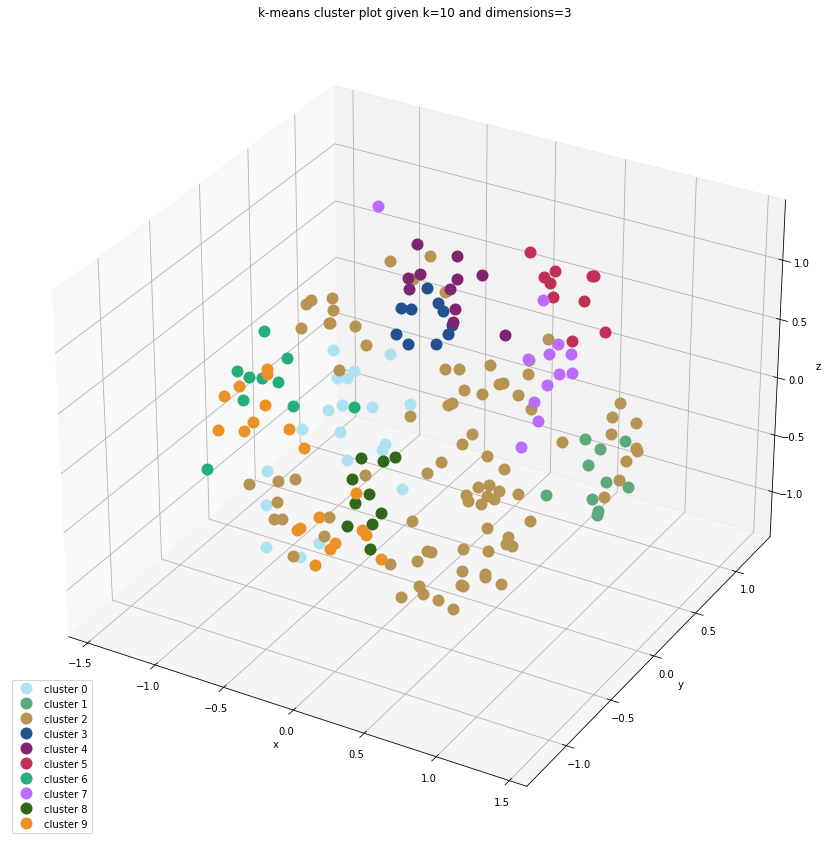

In [34]:
plot_kmeans(k_value=10, dimensions=3)

cluster 0 :  ['DWM_Doc1_TheLostCity', 'DWM_Doc2_TheLostCity', 'DWM_Doc3_TheLostCity', 'DWM_Doc4_TheLostCity', 'DWM_Doc5_TheLostCity', 'DWM_Doc6_TheLostCity', 'DWM_Doc7_TheLostCity', 'DWM_Doc8_TheLostCity', 'DWM_Doc9_TheLostCity', 'DWM_Doc10_TheLostCity'] 

cluster 1 :  ['DRN_Doc4_EQUILIBRIUM', 'DRN_Doc5_EQUILIBRIUM', 'DRN_Doc9_EQUILIBRIUM', 'RSV_Doc1_MinorityReport', 'RSV_Doc2_MinorityReport', 'RSV_Doc3_MinorityReport', 'RSV_Doc4_MinorityReport', 'RSV_Doc5_MinorityReport', 'RSV_Doc6_MinorityReport', 'RSV_Doc7_MinorityReport', 'RSV_Doc8_MinorityReport', 'RSV_Doc9_MinorityReport', 'RSV_Doc10_MinorityReport', 'JTG_Doc1_Oblivion', 'JTG_Doc2_Oblivion', 'JTG_Doc3_Oblivion', 'JTG_Doc4_Oblivion', 'JTG_Doc5_Oblivion', 'JTG_Doc6_Oblivion', 'JTG_Doc7_Oblivion', 'JTG_Doc8_Oblivion', 'JTG_Doc9_Oblivion', 'JTG_Doc10_Oblivion', 'JLV_Doc1_Batman', 'JLV_Doc2_Batman', 'JLV_Doc3_Batman', 'JLV_Doc4_Batman', 'JLV_Doc5_Batman', 'JLV_Doc6_Batman', 'JLV_Doc7_Batman', 'JLV_Doc8_Batman', 'JLV_Doc9_Batman', 'JLV

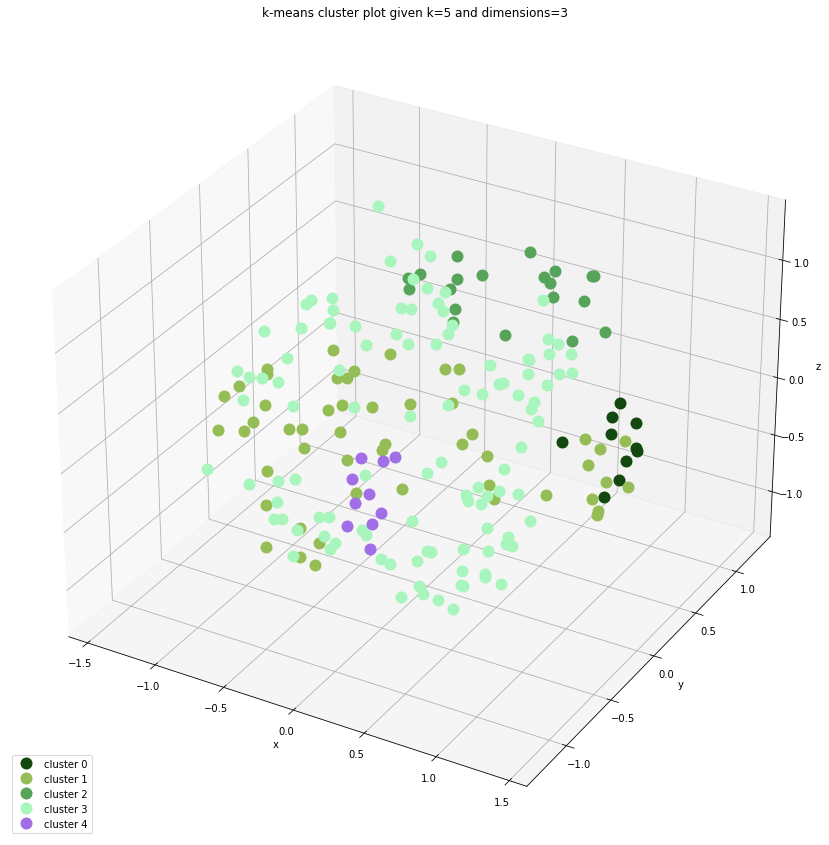

In [35]:
plot_kmeans(k_value=5, dimensions=3)

In [36]:
cluster_title, clusters, k_means_df, km = k_means(titles, tfidf_matrix, k = 4)

### Generate Labels for Supervised Learning Models

In [37]:
pos_neg_labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(pos_neg_labels)

0      0
1      1
2      0
3      0
4      0
      ..
195    0
196    0
197    0
198    0
199    0
Name: Review Type (pos or neg), Length: 200, dtype: int64


In [38]:
data['GenreCode'] = data['Genre of Movie'].astype("category").cat.codes
genre_labels = data['GenreCode']
print(genre_labels)

0      0
1      0
2      0
3      0
4      0
      ..
195    0
196    0
197    0
198    0
199    0
Name: GenreCode, Length: 200, dtype: int8


### Naive Bayes

<div class="alert alert-block alert-success">
    <b>Naive Bayes</b>:<br> 
https://scikit-learn.org/stable/modules/naive_bayes.html<br><br>
    Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.
    </div>

In [39]:
classifiers(tfidf_matrix, pos_neg_labels, 'naive_bayes')

naive_bayes


[0.5, 0.3, 0.4]

In [40]:
classifiers(tfidf_matrix, genre_labels, 'naive_bayes')

naive_bayes


[1.0, 1.0, 1.0]

### Logistic Regression Model 

<div class="alert alert-block alert-success">
    <b>sklearn.linear_model.LogisticRegression</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html<br><br>
<b>Logistic Regression Default Parameters</b>:<br>
    class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
    </div>

In [41]:
classifiers(tfidf_matrix, pos_neg_labels, 'logistic')

logistic


[0.35, 0.25, 0.35]

In [42]:
classifiers(tfidf_matrix, genre_labels, 'logistic')

logistic


[1.0, 1.0, 1.0]

### Random Forest

<div class="alert alert-block alert-success">
    <b>sklearn.ensemble.RandomForestClassifier</b>:<br> 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html<br><br>
<b>RandomForest Classifier Default Parameters</b>:<br>
    class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
    </div>

In [43]:
classifiers(tfidf_matrix, pos_neg_labels, 'randomforest')

randomforest


[0.55, 0.4, 0.5]

In [44]:
classifiers(tfidf_matrix, genre_labels, 'randomforest')

randomforest


[0.95, 1.0, 1.0]

In [45]:
# dark purple means it didnt converge; it's just random
# not rly any underlying __ concepts being extracted based on model

In [46]:
# tdm matrix as input

In [47]:
# it seems random forest model doesn't perform well on the genres but it
# does outperform logistic regression and naive bayes on the posi/neg reviews.

In [ ]:
# you want like a scree plot
# with confusion matrix
# add precision, recall, f1 score

# add model type
# add whether you stemmed, lemm'ed

# for pos/neg review prediction

# divide data by genre
# pos/neg review prediction
# just for cluster 1
# what does it think?

# track the number of dimensions - before cleaning, after cleaning